## Analyse client approfondie 

Le but de ce NoteBook est de réalisée une analyse plus approfondie ciblée client afin de pouvoir prendre des décisions business approppriée.

Import des packages nécessaires et modification du format de la date.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/online_retail_clean.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## Construction de la table client

L'objectif de cette étape est de passer d'un niveau transactionnel à un niveau client.

Chaque client est résumé à l'aide de plusieurs indicateurs clés :

- NbOrders : Nombre de commandes distinctes passées par le client.
Cette variable permet d'évaluer la fidélité du client.

- TotalQuantity : Quantité totale de produits achetés par le client.
Elle reflète le volume global de consommation du client.

- TotalSpent : Montant total dépense par le client.
Il s'agit de l'indicateur direct de la valeur économique du client.

Cette table est essentielle car elle constitue la base de l'analyse client.
Elle permet d'identifier les clients à forte valeur, d'analyser la répartition du chiffre d'affaires et de construire des segmentations clients orientées décision business.

In [2]:
customer_df = df.groupby('CustomerID').agg({
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

In [3]:
customer_df = customer_df.rename(columns={
    'Invoice': 'NbOrders',
    'Quantity': 'TotalQuantity',
    'TotalPrice': 'TotalSpent'
})

Top client par dépenses

In [4]:
customer_df.sort_values('TotalSpent', ascending=False).head(10)

,CustomerID,NbOrders,TotalQuantity,TotalSpent
5692,18102.0,145,181645,580987.04
2277,14646.0,151,367193,528602.52
1789,14156.0,156,164325,313437.62
2538,14911.0,398,147972,291420.81
5050,17450.0,51,83914,244784.25
1331,13694.0,143,188201,195640.69
5109,17511.0,60,117174,172132.87
4061,16446.0,2,80997,168472.50
4295,16684.0,55,104810,147142.77
68,12415.0,28,91447,144458.37


Distribution des dépenses

In [5]:
customer_df['TotalSpent'].describe()

count      5878.000000
mean       2955.904095
std       14440.852688
min           2.950000
25%         342.280000
50%         867.740000
75%        2248.305000
max      580987.040000
Name: TotalSpent, dtype: float64

Visualisation simple

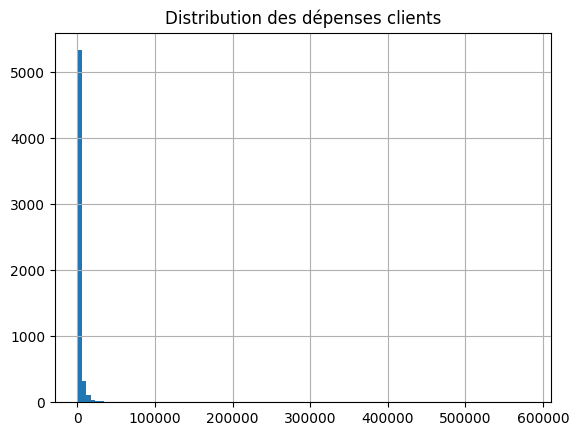

In [6]:
customer_df['TotalSpent'].hist(bins=100)
plt.title('Distribution des dépenses clients')
plt.show()

## Lecture métier - Répartition du CA

L'analyse de la répartition du CA par client montre une forte concentration des revenus.

Une très faible proportion de clients génère la majorité du chiffre d'affaires, tandis que la grande majorité des clients contribue de manière marginale.
Cette distribution est caractéristique d'une logique de type Pareto (80/20) et d'un phénomène de "Long Tail"

Ce constat met en évidence l'importance stratégique des clients à forte valeur, ainsi que la nécessité de mettre en place des actions différenciées selon les segments de clients.

Date de référence (ici on prend la date la plus récente)

In [7]:
reference_date = df['InvoiceDate'].max()

Calcul RFM

In [8]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique', 
    'TotalPrice': 'sum'
}).reset_index()

Renommage des colonnes :

Recency = récence d'achat
Frequency = fidélité
Monetary = valeur client

In [9]:
rfm = rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
})

Cette étape permet d'identifier différents profils clients à partir des indicateurs RFM : clients à forte valeur, clients fidèles, et clients présentant un risque de churn en raison d'une forte ancienneté de leur dernière commande.

Ces segments peuvent servir de base à des actions marketing différenciées.

In [10]:
rfm['Segment'] = 'Standard'

rfm.loc[(rfm['Monetary'] > rfm['Monetary'].quantile(0.75)) & (rfm['Frequency'] > rfm['Frequency'].quantile(0.75)), 'Segment'] = 'Top Clients'
rfm.loc[rfm['Recency'] > rfm['Recency'].quantile(0.75), 'Segment'] = 'Clients à risque'

rfm['Segment'].value_counts()

Segment
Standard            3352
Clients à risque    1459
Top Clients         1067
Name: count, dtype: int64

In [11]:
customer_df.to_csv('../data/customer_aggregates.csv', index=False)
rfm.to_csv('../data/rfm_clients.csv', index=False)

## Conclusion - Analyse Client

L’analyse RFM a permis d’identifier différents profils de clients, notamment
les clients à forte valeur, les clients fidèles et les clients à risque.
Cette segmentation offre une vision claire de la base clients et constitue
un levier pertinent pour orienter des actions de fidélisation, de réactivation
ou de priorisation des clients à fort potentiel.